# Image Classification with Logistic Regression from Scratch with NumPy

Welcome to another jupyter notebook of implementing machine learning algorithms from scratch using only NumPy. This time we will be implementing a different version of logistic regression for a simple image classification task. I've already done a basic version of logistic regression before [here](https://github.com/leventbass/logistic_regression). This time, we will use logistic regression to classify images. I will show all necessary mathematical equations of logistic regression and how to vectorize the summations in the equations. We will be working with a subset of the famous handwritten digit dataset called MNIST. In the subset, there will only be images of digit 1 and 5. Therefore, we will be solving a binary classification problem. 

This notebook includes feature extraction, model training, and evaluation steps. Let's see what we will achieve in this post in steps:

* First, we wil load and visualize the dataset and extract two different set of features to build a classifier on.

* We will run our logistic regression algorithm with gradient descent the representations to classify digits into 1 and 5.

* We will experiment with different learning rates to find the best one.

* Finally, we will evaluate the implemented models, decide which is the best performing one and visualize a decision boundary.

* Once again, let's remind ourselves that we won't be using any function or library that accomplishes the task itself. For instance, we won't use scikit-learn to implement cross validation, we will use numpy for that and for all of the other tasks. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Feature Extraction

Let's load the training/test data and labels as numpy arrays. All data that is used is provided in the repository in data folder. Train and test data are 1561x256 and 424x256 dimensional matrices, respectively. Each row in the aforementioned matrices corresponds to an image of a digit. The 256 pixels correspond to a 16x16 image. Label 1 is assigned to digit 1 and label -1 is assigned to digit 5.

In [2]:
train_x = np.load('data/train_data.npy')
train_y = np.load('data/train_labels.npy')
test_x = np.load('data/test_data.npy')
test_y = np.load('data/test_labels.npy')

Now, let's display two of the digit images, one for digit 1 and one for digit 5. We will use `imshow` function of `matplotlib` library with a suitable colormap. We will first need to reshape 256 pixels to a 16x16 matrix. 

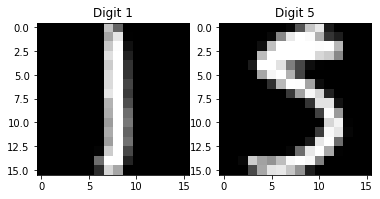

In [3]:
digit_1 = train_x[0].reshape((16,16))
digit_5 = train_x[-1].reshape((16,16))

plt.subplot(121, title='Digit 1')
plt.imshow(digit_1, cmap='gray');
plt.subplot(122, title='Digit 5')
plt.imshow(digit_5, cmap='gray');

**Implementing Representation 1:**
Now, we will extract the **symmetry** and **average intensity** features to use in the model. To compute the intensity features, we compute the average pixel value of the image, and for the symmetry feature, we compute the negative of the norm of the difference between the image and its y-axis symmetrical. We will extract these two features for each image in the training and test sets. As a result, we should obtain a training data matrix of size 1561x2 and test data matrix of size 424x2.

Throughout the notebook, we will refer the representation with these two features as **Representation 1** 

In [6]:
train_feature_1 = np.mean(train_x, axis=1)
test_feature_1 = np.mean(test_x, axis=1)

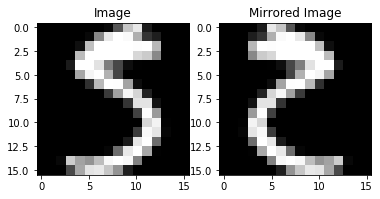

In [7]:
mirrored_image_train = np.flip(train_x.reshape((train_x.shape[0],16,16)), axis=2)
mirrored_image_test = np.flip(test_x.reshape((test_x.shape[0],16,16)), axis=2)
    
plt.subplot(121, title='Image')
plt.imshow(train_x[-1].reshape((16,16)), cmap='gray');
plt.subplot(122, title='Mirrored Image')
plt.imshow(mirrored_image_train[-1], cmap='gray');


In [8]:
train_diff = train_x - mirrored_image_train.reshape((mirrored_image_train.shape[0],256))
test_diff = test_x - mirrored_image_test.reshape((mirrored_image_test.shape[0],256))

norm_train_diff = np.linalg.norm(train_diff, axis=1)
norm_test_diff = np.linalg.norm(test_diff, axis=1)

train_feature_2 = -(norm_train_diff)
test_feature_2 = -(norm_test_diff)

train_X_1 = np.concatenate((train_feature_1[:,np.newaxis], train_feature_2[:,np.newaxis]), axis=1)
test_X_1 = np.concatenate((test_feature_1[:,np.newaxis], test_feature_2[:,np.newaxis]), axis=1)

Now, let's provide two scatter plots, one for training and one for test data. The plots will contain the average intensity values in the x-axis and symmetry values in the y-axis. We will denote the data points of label 1 with blue marker shaped <font color='blue'>o</font> and the data points of label -1 with a red marker shaped <font color='red'>x</font>.

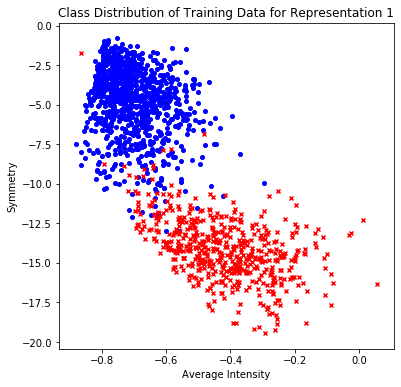

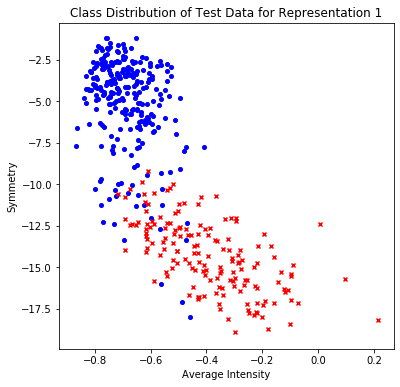

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(train_X_1[(train_y==1),0], train_X_1[(train_y==1),1], marker='o', color='blue', s=16)
plt.scatter(train_X_1[(train_y==-1),0], train_X_1[(train_y==-1),1], marker='x', color='red', s=16)
plt.title('Class Distribution of Training Data for Representation 1')
plt.xlabel('Average Intensity')
plt.ylabel('Symmetry')

plt.figure(figsize=(6,6))
plt.scatter(test_X_1[(test_y==1),0], test_X_1[(test_y==1),1], marker='o', color='blue', s=16)
plt.scatter(test_X_1[(test_y==-1),0], test_X_1[(test_y==-1),1], marker='x', color='red', s=16)
plt.title('Class Distribution of Test Data for Representation 1')
plt.xlabel('Average Intensity')
plt.ylabel('Symmetry');

**Implementing Representation 2:** We will come up with an alternative feature extraction approach and we will refer this representation as **Representation 2**.

In [10]:
train_rep2_fet1 = np.array([(i>-1).sum() for i in train_x])/(train_x.shape[0]) # feature 1 for representation 2
test_rep2_fet1 = np.array([(i>-1).sum() for i in test_x])/(test_x.shape[0])

In [11]:
train_rep2_fet2 = np.std(train_x, axis=1) # feature 2 for representation 2
test_rep2_fet2 = np.std(test_x, axis=1)

In [12]:
train_X_2 = np.concatenate((train_rep2_fet1[:,np.newaxis], train_rep2_fet2[:,np.newaxis]), axis=1)
test_X_2 = np.concatenate((test_rep2_fet1[:,np.newaxis], test_rep2_fet2[:,np.newaxis]), axis=1)

To create the first feature of representation 2, we sum up all of the pixel values that are higher than -1 since pixel values of -1 represent the surrounding area of the image and not itself. By summing up those values we get a number that would be clearly distinctive for image of number 5 and 1, because evidently number 5 would take up more space than number 1 when it is drawn. 

To add another feature to representation 2, let's calculate the standard deviation of the images. Image of number 5 will obviously have more standard deviation than image of number 1 because of the fact that it is more dispersed throughtout the area than number 1, while pixel values of number 1 are more confined and closer to each other than the image of number 5. Hence, taking the standard deviation of pixel values would be a differentiating factor for our images.

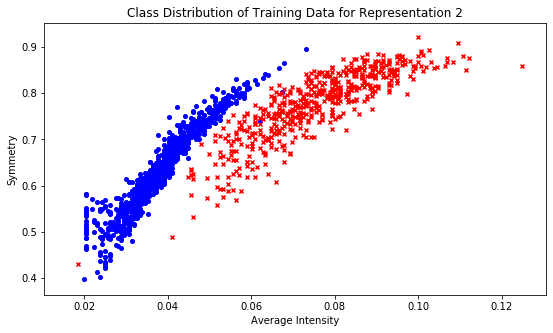

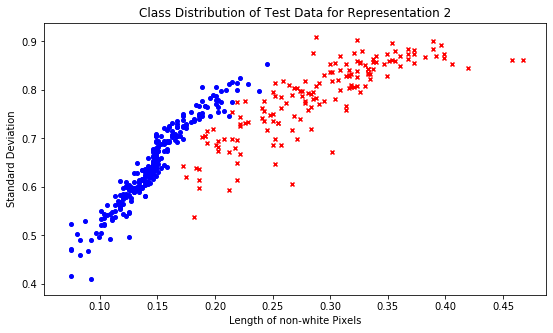

In [13]:
plt.figure(figsize=(9,5))
plt.scatter(train_X_2[(train_y==1),0], train_X_2[(train_y==1),1], marker='o', color='blue', s=16)
plt.scatter(train_X_2[(train_y==-1),0], train_X_2[(train_y==-1),1], marker='x', color='red', s=16)
plt.title('Class Distribution of Training Data for Representation 2')
plt.xlabel('Average Intensity')
plt.ylabel('Symmetry')

plt.figure(figsize=(9,5))
plt.scatter(test_X_2[(test_y==1),0], test_X_2[(test_y==1),1], marker='o', color='blue', s=16)
plt.scatter(test_X_2[(test_y==-1),0], test_X_2[(test_y==-1),1], marker='x', color='red', s=16)
plt.title('Class Distribution of Test Data for Representation 2')
plt.xlabel('Length of non-white Pixels')
plt.ylabel('Standard Deviation');


## Logistic Regression

Let's implement the logistic regression classifier from scratch with gradient descent and train it using Representation 1 and Representation 2 as inputs. We will concatenate 1 to our features for the intercept term, such that one data point will look like for 2-D features [1,$x_1$,$x_2$], and the model vector will be [$w_0, w_1, w_2$], where $w_0$ is the intercept parameter. 


In [14]:
def data_init(X, y):
    y = y[:,np.newaxis]

    m = len(y)

    X = np.hstack((np.ones((m,1)),X))
    

    n = np.size(X,1)
    params = np.zeros((n,1))
    
    return (X, y, params)

To implement the gradient of the logistic loss with respect to $w$, first let's derive its expression:

Total cost is:

$E(w) = \frac{1}{N} \sum_{n=1}^{N} \ln \left(1 + \exp \left(-y^{\left(n\right)} w^T x^{\left(n\right)}\right)\right)$
  &nbsp;

Cost for one sample is:


$E \left(w^{\left(1\right)} \right) = \ln \left(1 + \exp \left(-y^{\left(1\right)} w^T x^{\left(1\right)} \right) \right)$
  
where;

$y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix}_{N\times 1}$
$x = \begin{bmatrix} 1 & {x_1}^{\left(1\right)} & {x_2}^{\left(1\right)} \\
                    1 & {x_1}^{\left(2\right)} & {x_2}^{\left(2\right)} \\
                    \vdots & \vdots & \vdots \\
                    1 & {x_1}^{\left(N\right)} & {x_2}^{\left(N\right)}\end{bmatrix}_{N\times 3}$
$w = \begin{bmatrix}w_0 \\ w_1 \\ w_2 \end{bmatrix}_{3\times 1}$

  &nbsp;
 
Let $z = -y^{\left(1\right)} w^T x^{\left(1\right)}$:

 &nbsp;

$\begin{aligned}
\frac{\partial E}{\partial w_0} &=  \frac{\partial \ln(1 + \exp(z))}{\partial w_0} \\
 &=\frac{\exp(z) \frac{\partial z}{\partial w_0}}{1 + \exp(z)} 
   \quad \left( \theta(z) = \frac{\exp(z)}{1 + \exp(z)} \right)\\
 &= \theta(z) \frac{\partial z}{\partial w_0} \\
 &= \theta\left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right)
 \frac{\partial \left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right)}{\partial w_0} \\ 
 &= \theta\left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right)
 \frac{\partial \left(-y^{\left(1\right)} \left(w_0 + w_1 {x_1}^{\left(1\right)} + w_2 {x_2}^{\left(1\right)}\right)\right)}{\partial w_0}\\
 \frac{\partial E}{\partial w_0} &= \theta\left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right) \left( -y^{\left(1\right)} \right) \\
\frac{\partial E}{\partial w_1} &=  \theta\left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right) \left( -y^{\left(1\right)} {x_1}^{\left(1\right)} \right)\\
\frac{\partial E}{\partial w_2} &=  \theta\left(-y^{\left(1\right)} w^T x^{\left(1\right)}\right) \left( -y^{\left(1\right)} {x_2}^{\left(1\right)} \right)\\
\end{aligned}$

  &nbsp;
$\begin{aligned}
\nabla E (w) &= \frac{1}{N} \sum_{n=1}^{N} -\theta \left(-y^{\left(n\right)} w^T x^{\left(n\right)}\right) y^{\left(n\right)} x^{\left(n\right)}\\
&= \frac{1}{N} {\left( - \textbf{y} \circ \textbf{x} \right)}^T \cdot \theta \left( -\textbf{y} \circ \textbf{x w} \right)
\end{aligned}$


To prove that our implementation is converging, we will keep the loss values at each gradient descent iteration in a numpy array. To decide when to terminate the gradient descent iterations, we will check the absolute difference between the current loss value and the loss value of the previous step. If the difference is less than a small number, such as $10^{-5}$, we will exit the loop.

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradient_descent(X, y, params, learning_rate):
    m = len(y)
   
    cost_history = []
    i=0
    while(True):
        params = params - (learning_rate/m) * ((-y * X).T @ sigmoid(-y * (X @ params)))
        cost_history.append(compute_cost(X, y, params))
        
        if(i!=0 and abs(cost_history[i] - cost_history[i-1]) < 10**-5):
            break;
            
        i+=1
    cost_history = np.array(cost_history)
    return (cost_history, params)

def compute_cost(X, y, theta):
    N = len(y)
    cost = np.sum(np.log(1+np.exp(-y * (X @ theta)))) / N
    return cost
    

After the training is finalized, we will plot the loss values with respect to iteration count. Obviously, we should observe a decreasing loss as the number of iterations increases. Also, we will experiment with 5 different learning rates between 0 and 1, and plot the convergence curves for each learning rate in the same plot to observe the effect of the learning rate (step size) on the convergence. 

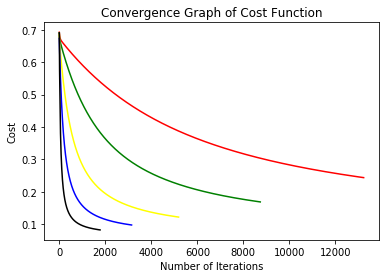

In [16]:
(X, y, params) = data_init(train_X_1, train_y)

lr_list = [0.001, 0.003, 0.01, 0.03, 0.1]
c_list = ['red', 'green', 'yellow', 'blue','black']

plt.figure()
for lr, color in zip(lr_list, c_list):
    (cost_history, params_optimal) = gradient_descent(X, y, params, lr)
    plt.plot(range(len(cost_history)),cost_history, c=color);
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

## Evaluation

Now, let's train the logistic regression classifier on Representation 1 and 2 with the best learning rate we have used so far. We will report the training and test classification accuracy as:

\begin{align*}
\frac{\text{number of correctly classified samples}}{\text{total number of samples}}x100
\end{align*}

In [20]:
def predict(X, params):
    y_pred_dummy = np.round(sigmoid(X @ params))
    y_pred = np.where(y_pred_dummy==0,-1,1)
    return y_pred

def get_accuracy(y_pred, y):
    score = float(sum(y_pred == y))/ float(len(y)) * 100
    
    return score

def evaluate(train_X, train_y, test_X, test_y, learning_rate, lambda_param):

    (X, y, params) = data_init(train_X, train_y)

    (_, params_optimal_1) = gradient_descent(X, y, params, learning_rate)

    
    X_normalized = test_X

    X_test = np.hstack((np.ones((X_normalized.shape[0],1)),X_normalized))

    y_pred_train = predict(X, params_optimal_1)

    train_score = get_accuracy(y_pred_train, y)
    print('Training Score:',train_score)

    y_pred_test = predict(X_test, params_optimal_1)

    test_score = get_accuracy(y_pred_test, test_y[:,np.newaxis])
    print('Test Score:',test_score)

In [21]:
print('Evaluation results for Representation 1:')
print('-'*50)
evaluate(train_X_1, train_y, test_X_1, test_y, 0.1, 0.0003)

print('\nEvaluation results for Representation 2:')
print('-'*50)
evaluate(train_X_2, train_y, test_X_2, test_y, 0.1, 0.0001)

Evaluation results for Representation 1:
--------------------------------------------------
Training Score: 97.69378603459322
Test Score: 95.04716981132076

Evaluation results for Representation 2:
--------------------------------------------------
Training Score: 83.27994875080077
Test Score: 81.13207547169812


Last but not least, we will visualize the decision boundary (the line that is given by $\mathbf{w}^{T}x=0$) obtained from the logistic regression classifier learned. For this purpose, we will only use Representation 1. Below, two scatter plots can be seen for training and test data points with the decision boundary shown on each of the plots.

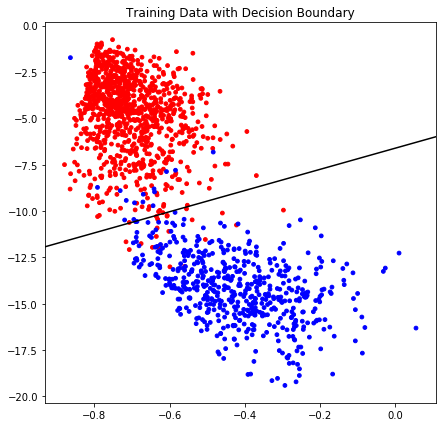

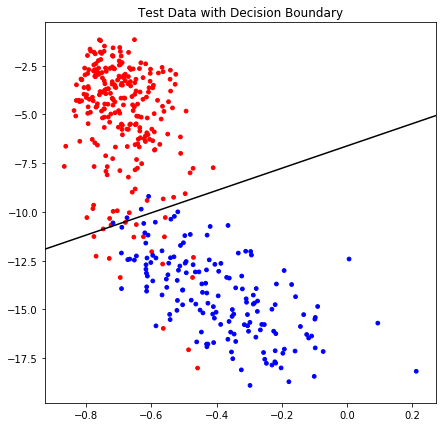

In [22]:
(X, y, params) = data_init(train_X_1,train_y)

learning_rate = 0.1

(_, params_optimal_1) = gradient_descent(X, y, params, learning_rate)
slope = -(params_optimal_1[1] / params_optimal_1[2])
intercept = -(params_optimal_1[0] / params_optimal_1[2])

titles = ['Training Data with Decision Boundary', 'Test Data with Decision Boundary']

for X, y, title in [(train_X_1, y, titles[0]), (test_X_1, test_y, titles[1])]:
    plt.figure(figsize=(7,7))
    plt.scatter(X[:,0],X[:,1],c=y.reshape(-1), s=14, cmap='bwr')
    ax = plt.gca()
    ax.autoscale(False)
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + (slope * x_vals)
    plt.title(title);
    plt.plot(x_vals, y_vals, c='k')
   